In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

KeyboardInterrupt: ignored

In [0]:
import zipfile
with zipfile.ZipFile("/gdrive/My Drive/MNIST/MNIST.zip","r") as zip_ref:
    zip_ref.extractall("/gdrive/My Drive/MNIST")

In [0]:
import os
from time import localtime, strftime

from glob import glob
import numpy as np
import cv2
import matplotlib.image as mpimg 
import scipy.io


def time():
    return strftime('%m%d_%H%M', localtime())

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

class DataLoader():
    total_imgs = []
    def __init__(self, dataset_name, img_res=(32, 32), mem_load=True):

        self.mem_load = mem_load
        self.dataset_name = dataset_name
        self.img_res = img_res
        
        matx = scipy.io.loadmat('/gdrive/My Drive/MNIST/Train/train_x_'+str(0)+'.mat')
        matx = matx['train_x'];
        self.total_imgs = matx;
        
        for i in range(9):
            matx = scipy.io.loadmat('/gdrive/My Drive/MNIST/Train/train_x_'+str(i+1)+'.mat')
            matx = matx['train_x'];
            self.total_imgs = np.append(self.total_imgs, matx, axis=0);
        self.total_imgs = self.total_imgs.reshape(self.total_imgs.shape[0],32,32,1)
        self.total_imgs = self.total_imgs.astype('float32')
        self.total_imgs = np.array(self.total_imgs) / 127.5 -1.
        self.n_data = np.shape(self.total_imgs)[0]
        
     
    def load_data(self, batch_size=1, is_testing=False):
        imgs = [] # images to be returned
        if self.mem_load:
            idx = np.random.choice(range(self.n_data), size=batch_size)
            for i in idx:
                imgs.append(self.total_imgs[i])
            imgs = np.array(imgs)
        else:
            batch_images = np.random.choice(self.path, size=batch_size)

            for img_path in batch_images:
                img = self.imread(img_path)
                # If training => do random flip
                # if not is_testing and np.random.random() < 0.5:
                    # img = np.fliplr(img)
                imgs.append(img)

            imgs = np.array(imgs) / 127.5 - 1.
        return imgs
    
    
    def get_n_data(self):
        return self.n_data


---------------------generator summary----------------------------
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_4 (Reshape)          (None, 2, 2, 1024)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 2, 2, 1024)        4096      
_________________________________________________________________
activation_19 (Activation)   (None, 2, 2, 1024)        0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 4, 4, 512)         13107712  
_________________________________________________________________
batch_nor

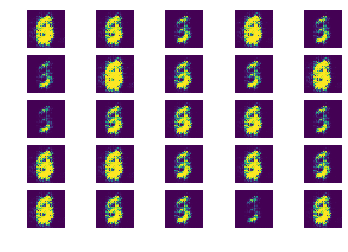

epoch:1 | iter : 200 / 937 | time : 0:00:42.214032 | g_loss :        3.299745 | d_loss_real : [0.017146178, 0.0] | d_loss_fake : [0.02574567, 1.0] 
epoch:1 | iter : 220 / 937 | time : 0:00:45.515435 | g_loss :       3.7695413 | d_loss_real : [0.019041821, 0.0] | d_loss_fake : [0.0017685341, 1.0] 
epoch:1 | iter : 240 / 937 | time : 0:00:48.783896 | g_loss :        3.958477 | d_loss_real : [0.021526568, 0.0] | d_loss_fake : [0.000535554, 1.0] 
epoch:1 | iter : 260 / 937 | time : 0:00:52.049006 | g_loss :        3.125573 | d_loss_real : [0.039860003, 0.0] | d_loss_fake : [0.010292739, 1.0] 
epoch:1 | iter : 280 / 937 | time : 0:00:55.311359 | g_loss :       3.7904174 | d_loss_real : [0.058472857, 0.0] | d_loss_fake : [0.010024007, 1.0] 
epoch:1 | iter : 300 / 937 | time : 0:00:58.575767 | g_loss :       3.5465941 | d_loss_real : [0.02483002, 0.0] | d_loss_fake : [0.003225505, 1.0] 
epoch:1 | iter : 320 / 937 | time : 0:01:01.841445 | g_loss :       3.3247685 | d_loss_real : [0.014767364,

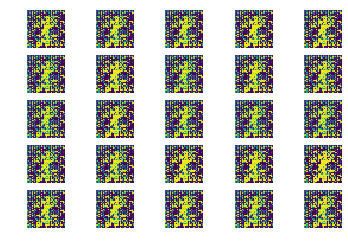

epoch:1 | iter : 400 / 937 | time : 0:01:15.740234 | g_loss :        3.859126 | d_loss_real : [0.0044173053, 0.0] | d_loss_fake : [0.00087521435, 1.0] 
epoch:1 | iter : 420 / 937 | time : 0:01:19.010625 | g_loss :         4.13208 | d_loss_real : [0.0046457206, 0.0] | d_loss_fake : [0.0040558013, 1.0] 
epoch:1 | iter : 440 / 937 | time : 0:01:22.286473 | g_loss :       3.7933898 | d_loss_real : [0.0031326464, 0.0] | d_loss_fake : [0.0018842843, 1.0] 
epoch:1 | iter : 460 / 937 | time : 0:01:25.556529 | g_loss :       3.8002465 | d_loss_real : [0.0036526644, 0.0] | d_loss_fake : [0.00083455147, 1.0] 
epoch:1 | iter : 480 / 937 | time : 0:01:28.810909 | g_loss :        4.633419 | d_loss_real : [0.0033657826, 0.0] | d_loss_fake : [0.00024293762, 1.0] 
epoch:1 | iter : 500 / 937 | time : 0:01:32.084729 | g_loss :       4.5284233 | d_loss_real : [0.005586316, 0.0] | d_loss_fake : [0.01218164, 1.0] 
epoch:1 | iter : 520 / 937 | time : 0:01:35.357480 | g_loss :       6.5134683 | d_loss_real : 

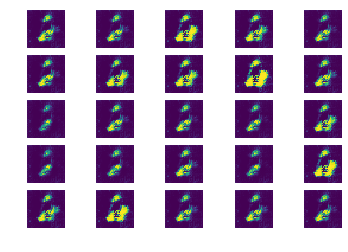

epoch:1 | iter : 600 / 937 | time : 0:01:49.260823 | g_loss :       3.1438146 | d_loss_real : [0.004112656, 0.0] | d_loss_fake : [0.01057875, 1.0] 
epoch:1 | iter : 620 / 937 | time : 0:01:52.531839 | g_loss :        3.886372 | d_loss_real : [0.048421912, 0.0] | d_loss_fake : [0.0016578716, 1.0] 
epoch:1 | iter : 640 / 937 | time : 0:01:55.800602 | g_loss :        4.344472 | d_loss_real : [0.041841842, 0.0] | d_loss_fake : [0.041103788, 1.0] 
epoch:1 | iter : 660 / 937 | time : 0:01:59.070288 | g_loss :        6.764949 | d_loss_real : [0.03900566, 0.0] | d_loss_fake : [0.15396895, 0.6875] 
epoch:1 | iter : 680 / 937 | time : 0:02:02.337514 | g_loss :        4.148906 | d_loss_real : [0.059679348, 0.0] | d_loss_fake : [0.008890502, 1.0] 
epoch:1 | iter : 700 / 937 | time : 0:02:05.606955 | g_loss :       3.6121008 | d_loss_real : [0.047554664, 0.0] | d_loss_fake : [0.020823862, 1.0] 
epoch:1 | iter : 720 / 937 | time : 0:02:08.877106 | g_loss :        2.733612 | d_loss_real : [0.07954208

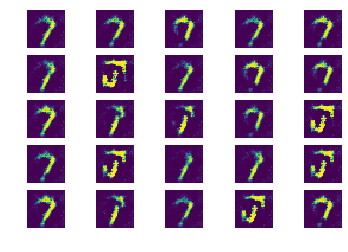

epoch:1 | iter : 800 / 937 | time : 0:02:22.791645 | g_loss :        2.973813 | d_loss_real : [0.01126636, 0.0] | d_loss_fake : [0.023460561, 1.0] 
epoch:1 | iter : 820 / 937 | time : 0:02:26.063303 | g_loss :       3.2089543 | d_loss_real : [0.023489987, 0.0] | d_loss_fake : [0.0046662698, 1.0] 
epoch:1 | iter : 840 / 937 | time : 0:02:29.336852 | g_loss :       3.4440098 | d_loss_real : [0.042945288, 0.0] | d_loss_fake : [0.016974263, 1.0] 
epoch:1 | iter : 860 / 937 | time : 0:02:32.611347 | g_loss :       2.8724284 | d_loss_real : [0.082944125, 0.0] | d_loss_fake : [0.004598489, 1.0] 
epoch:1 | iter : 880 / 937 | time : 0:02:35.885608 | g_loss :       3.0775235 | d_loss_real : [0.025217436, 0.0] | d_loss_fake : [0.03333089, 0.96875] 
epoch:1 | iter : 900 / 937 | time : 0:02:39.160209 | g_loss :        4.855857 | d_loss_real : [0.055445, 0.0] | d_loss_fake : [0.111302376, 0.859375] 
epoch:1 | iter : 920 / 937 | time : 0:02:42.434302 | g_loss :        3.075529 | d_loss_real : [0.0650

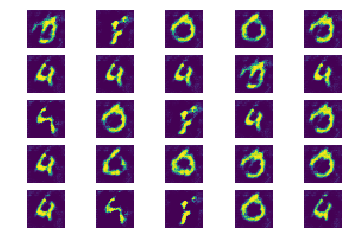

epoch:2 | iter : 200 / 937 | time : 0:03:23.247433 | g_loss :       3.7638826 | d_loss_real : [0.017615065, 0.0] | d_loss_fake : [0.056683745, 1.0] 
epoch:2 | iter : 220 / 937 | time : 0:03:26.516800 | g_loss :       3.3866158 | d_loss_real : [0.013608225, 0.0] | d_loss_fake : [0.045928076, 1.0] 
epoch:2 | iter : 240 / 937 | time : 0:03:29.787238 | g_loss :       3.2613335 | d_loss_real : [0.021025453, 0.0] | d_loss_fake : [0.017900348, 1.0] 
epoch:2 | iter : 260 / 937 | time : 0:03:33.057861 | g_loss :       3.2972174 | d_loss_real : [0.030351512, 0.0] | d_loss_fake : [0.04513109, 1.0] 
epoch:2 | iter : 280 / 937 | time : 0:03:36.330772 | g_loss :       2.5920804 | d_loss_real : [0.022642687, 0.0] | d_loss_fake : [0.007999951, 1.0] 
epoch:2 | iter : 300 / 937 | time : 0:03:39.606696 | g_loss :       2.8775272 | d_loss_real : [0.012490736, 0.0] | d_loss_fake : [0.010098429, 1.0] 
epoch:2 | iter : 320 / 937 | time : 0:03:42.882464 | g_loss :        2.452064 | d_loss_real : [0.092221744,

KeyboardInterrupt: ignored

In [9]:
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2DTranspose, Conv2D
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os

DEBUG = 0

class DCGAN():
    def __init__(self):
        # Input shape
        self.channels = 1
        self.img_size = 32
        self.latent_dim = 200
        self.time = time()
        self.dataset_name = 'MNIST'
        self.learning_rate = 1e-4

        optimizer = Adam(self.learning_rate, beta_1=0.5, decay=0.00005)

        self.gf = 64 # filter size of generator's last layer
        self.df = 64 # filter size of discriminator's first layer

        # Configure data loader
        self.data_loader = DataLoader(dataset_name=self.dataset_name,
                                      img_res=(self.img_size, self.img_size), mem_load=True)
        
        
        self.n_data = self.data_loader.get_n_data()

        self.generator = self.build_generator()
        print("---------------------generator summary----------------------------")
        self.generator.summary()

        self.generator.compile(loss='mse',
                               optimizer=optimizer,
                               metrics=['mse'])

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        print("\n---------------------discriminator summary----------------------------")
        self.discriminator.summary()

        self.discriminator.compile(loss='mse',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        make_trainable(self.discriminator, False)

        z = Input(shape=(self.latent_dim,))
        fake_img = self.generator(z)

        # for the combined model, we only train ganerator
        self.discriminator.trainable = False

        validity = self.discriminator(fake_img)

        self.combined = Model([z], [validity])
        print("\n---------------------combined summary----------------------------")
        self.combined.summary()
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer)
        #print ("Metrics = "), print(self.discriminator.metrics_names)
        #print ("efsrfesr")

    def build_generator(self):
        noise = Input(shape=(self.latent_dim,))

        def deconv2d(layer_input, filters=256, kernel_size=(5, 5), strides=(2, 2), bn_relu=True):
            """Layers used during upsampling"""
            # u = UpSampling2D(size=2)(layer_input)
            u = Conv2DTranspose(filters, kernel_size=kernel_size, strides=strides, padding='same')(layer_input)
            if bn_relu:
                u = BatchNormalization(momentum=0.9)(u)
                u = Activation('relu')(u)
            return u

        generator = Dense(16 * self.gf * self.img_size // 16 * self.img_size // 16, activation="relu")(noise)
        generator = Reshape((self.img_size // 16, self.img_size // 16, self.gf * 16))(generator)
        generator = BatchNormalization()(generator)
        generator = Activation('relu')(generator)
        generator = deconv2d(generator, filters=self.gf * 8)
        generator = deconv2d(generator, filters=self.gf * 4)
        generator = deconv2d(generator, filters=self.gf * 2)
        generator = deconv2d(generator, filters=self.gf    )
        generator = deconv2d(generator, filters=self.channels, kernel_size=(3,3), strides=(1,1), bn_relu=False)

        gen_img = Activation('tanh')(generator)

        return Model(noise, gen_img)

    def build_discriminator(self):

        def d_block(layer_input, filters, strides=1, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            if bn:
                d = BatchNormalization(momentum=0.9)(d)
            d = LeakyReLU(alpha=0.2)(d)

            return d

        # Input img = generated image
        d0 = Input(shape=(self.img_size, self.img_size, self.channels))

        d = d_block(d0, self.df, strides=2, bn=False)
        d = d_block(d, self.df*2, strides=2)
        d = d_block(d, self.df*4, strides=2)
        d = d_block(d, self.df*8, strides=2)

        d = Flatten()(d)
        validity = Dense(1, activation='sigmoid')(d)

        return Model(d0, validity)

    def train(self, epochs, batch_size, sample_interval):
        def named_logs(model, logs):
            result = {}
            for l in zip(model.metrics_names, logs):
                result[l[0]] = l[1]
            return result

        start_time = datetime.datetime.now()

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        max_iter = int(self.n_data/batch_size)
        os.makedirs('./logs/%s' % self.time, exist_ok=True)
        tensorboard = TensorBoard('./logs/%s' % self.time)
        tensorboard.set_model(self.generator)

        os.makedirs('models/%s' % self.time, exist_ok=True)
        with open('models/%s/%s_architecture.json' % (self.time, 'generator'), 'w') as f:
            f.write(self.generator.to_json())
        print("\nbatch size : %d | num_data : %d | max iteration : %d | time : %s \n" % (batch_size, self.n_data, max_iter, self.time))
        for epoch in range(1, epochs+1):
            for iter in range(max_iter):
                # ------------------
                #  Train Generator
                # ------------------
                ref_imgs = self.data_loader.load_data(batch_size)

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                make_trainable(self.discriminator, True)
                d_loss_real = self.discriminator.train_on_batch(ref_imgs, valid*0.9)  # label smoothing
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                make_trainable(self.discriminator, False)

                logs = self.combined.train_on_batch([noise], [valid])
                tensorboard.on_epoch_end(iter, named_logs(self.combined, [logs]))

                if iter % (sample_interval // 10) == 0:
                    elapsed_time = datetime.datetime.now() - start_time
                    #print("epoch:%d | iter : %d / %d | time : %10s | g_loss : %15s | d_loss : %s " %
                    #      (epoch, iter, max_iter, elapsed_time, logs, d_loss))
                    print("epoch:%d | iter : %d / %d | time : %10s | g_loss : %15s | d_loss_real : %s | d_loss_fake : %s " %
                          (epoch, iter, max_iter, elapsed_time, logs, d_loss_real, d_loss_fake))
                    
                if (iter+1) % sample_interval == 0:
                    self.sample_images(epoch, iter+1)

            # save weights after every epoch
            self.generator.save_weights('models/%s/%s_epoch%d_weights.h5' % (self.time, 'generator', epoch))
            #self.discriminator.save_weights('models/%s/%s_epoch%d_weights.h5' % (self.time, 'discriminator', epoch))
            self.discriminator.save('models/%s/%s_epoch%d_weights.hdf5' % (self.time, 'discriminator_model', epoch))
            
    def sample_images(self, epoch, iter):
        os.makedirs('samples/%s' % self.time, exist_ok=True)
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r*c, self.latent_dim))
        gen_img = self.generator.predict(noise)
        
        gen_img = gen_img.reshape(gen_img.shape[0],32,32)
        # Rescale images 0 - 1
        gen_img = 0.5 * gen_img + 0.5

        # Save generated images and the high resolution originals
        fig, axs = plt.subplots(r, c)
        for row in range(r):
            for col in range(c):
                #plt.imshow(gen_img[5*row+col])
                #plt.show()
                axs[row, col].imshow(gen_img[5*row+col])
                axs[row, col].axis('off')
        plt.show()
        #fig.savefig("samples/%s/e%d-i%d.png" % (self.time, epoch, iter), bbox_inches='tight', dpi=100)
        plt.close()

if __name__ == '__main__':
    gan = DCGAN()
    
    gan.train(epochs=50, batch_size=64, sample_interval=200)